<a href="https://colab.research.google.com/github/OliveiraGmo/Machine-learning/blob/main/Recomenda%C3%A7%C3%A3o_de_imagens_por_similaridade_com_rede_neural_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminho para o conjunto de dados
data_dir = "/content/drive/MyDrive/Test"

# Parâmetros
img_size = (224, 224)  # Tamanho das imagens
batch_size = 32

# Data augmentation e pré-processamento
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normaliza os pixels para o intervalo [0, 1]
    validation_split=0.2,  # Divide 20% dos dados para validação
    horizontal_flip=True,  # Aumento de dados: flip horizontal
    rotation_range=20,  # Aumento de dados: rotação
)

# Carregar dados de treino e validação
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

Found 254 images belonging to 7 classes.
Found 61 images belonging to 7 classes.


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Carregar o modelo MobileNetV2 pré-treinado (sem a camada fully connected)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar novas camadas para as 7 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treinar o modelo
epochs = 16
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
)
model.save_weights('model.weights.h5')

Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.2749 - loss: 2.2652 - val_accuracy: 0.5312 - val_loss: 1.2664
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 588ms/step - accuracy: 0.4062 - loss: 1.7473 - val_accuracy: 0.6250 - val_loss: 1.0515
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6055 - loss: 1.0724 - val_accuracy: 0.5000 - val_loss: 1.3318
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6562 - loss: 0.7362 - val_accuracy: 0.5000 - val_loss: 1.2638
Epoch 5/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7290 - loss: 0.7659 - val_accuracy: 0.6875 - val_loss: 1.0211
Epoch 6/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 913ms/step - accuracy: 0.8750 - loss: 0.3978 - val_accuracy: 0.6875 - val_loss: 1.1229
Epoch 7/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8544 - loss: 0.4601 - val_accuracy: 0.7188 - val_loss: 0.8178
Epoch 8/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.7812 - loss: 0.5880 - val_accuracy: 0.5000 - val_loss: 1.1931
Ep

In [3]:
from tensorflow.keras.models import Model

# Criar um novo modelo para extrair embeddings
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)  # Camada antes da classificação

# Função para extrair embeddings de uma imagem
def extract_embedding(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalização
    embedding = embedding_model.predict(img)
    return embedding.flatten()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# Extrair embeddings de todas as imagens no banco de dados
embeddings = []
image_paths = []

for class_name in train_generator.class_indices:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        embedding = extract_embedding(img_path)
        embeddings.append(embedding)
        image_paths.append(img_path)

embeddings = np.array(embeddings)

# Função para recomendar imagens semelhantes
def recommend_similar_images(query_image_path, top_n=5):
    query_embedding = extract_embedding(query_image_path)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    top_indices = np.argsort(similarities)[-top_n:][::-1]  # Ordena do mais similar para o menos
    return [image_paths[i] for i in top_indices]

# Exemplo de uso
query_image_path = "/content/chanel curto.jpg"
similar_images = recommend_similar_images(query_image_path, top_n=5)

print("Imagens recomendadas:", similar_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

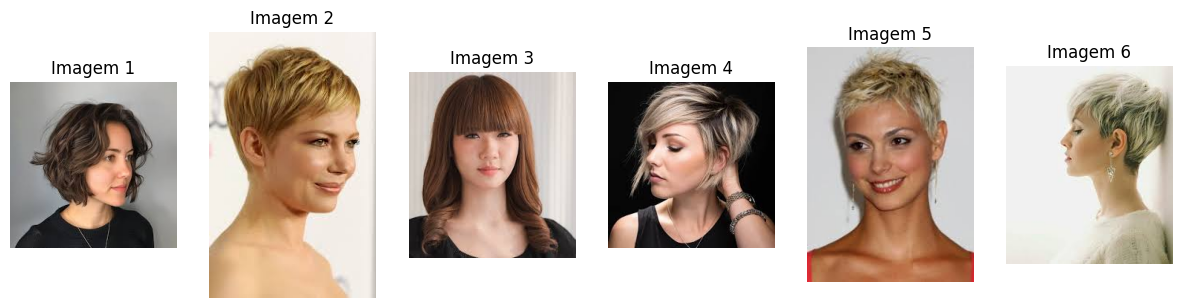

In [13]:
import matplotlib.pyplot as plt

# Função para exibir imagens
def show_images(image_paths):
    plt.figure(figsize=(15, 10))
    for i, path in enumerate(image_paths):
        img = tf.keras.preprocessing.image.load_img(path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f"Imagem {i + 1}")
        plt.axis("off")
    plt.show()

# Exibir a imagem de consulta e as imagens recomendadas
show_images([query_image_path] + similar_images)